### Data Processing for MATS31702 Research Project
##### Supercapacitor CV data

#### Imports (not all relevant)

In [10]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import special
import math
from statistics import stdev
import glob
import pandas as pd
from skimage import io
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
#import seaborn as sns
#sns.set()
from jupyterthemes import get_themes
import matplotlib.image as mpimg
from PIL import Image
import os
from jupyterthemes.stylefx import set_nb_theme
from scipy.integrate import simps
from numpy import trapz
set_nb_theme('oceans16')

#### Directory cell, allows file to be run on all WINDOWS operating systems as long as python file and CV folder within same fodler directory

In [9]:
os.chdir(str(os.getcwd())+"\CVs")
print(os.getcwd())
path=(str(os.getcwd()))
files=os.listdir(path)
print(files)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\wwwyu\\Desktop\\UoMyear3\\Research_python\\CVs\\CVs'

#### Relevant funtions for returning CV curves and calculated specific capacitance values

In [26]:
def integrate(y,x):#returns area under curve of data points (x,y)
    A=[]
    for i in range(len(y)-1):
        A.append((y[i]+y[i+1])*(x[i+1]-x[i]))
    return(sum(A)/1000000)
#file is the excel file, scanrate is the scan rate, mass is the active material mass

def get(file,scanrate,mass,*args):
    PNG_name=str(file[:-5])
    data=pd.read_excel(file).iloc[1:,:].dropna('columns', thresh=100)
    names=[]
    for i in range(int(data.shape[1]/2)):
        names.append('cycle_'+str(i+1))
    d={}#dictionary 
    for i in range(len(names)):
        d[names[i]]=data.iloc[:,0+i*2:2+i*2]
        
    if "all" in args:#returns all CV cycles for given scanrate in single plot
        plt.figure(figsize=(10,7))
        for value in names:
            i=d[value].iloc[:,0]
            v=d[value].iloc[:,1]
            
            plt.plot(i,v)
            #plt.title(file+' '+names[-1])
            plt.xlabel('voltage(V)')
            plt.ylabel('Current(mA)')
            plt.legend(names,bbox_to_anchor=(1,1))#gives all cycles on side
            plt.savefig(PNG_name+'all.png', bbox_inches = 'tight')

    if "sep" in args:#returns CV plots separately for each cycle
        for value in names:
            plt.figure(figsize=(12,9))
            i=d[value].iloc[:,0]
            v=d[value].iloc[:,1]
            plt.plot(i,v)
            #plt.title(value)
            plt.xlabel('voltage(V)')
            plt.ylabel('Current(mA)')
            
    if "avg" in args:#returns average CV curve from all cycles
        for value in names:
            v=d[value].iloc[:,1]
        data_i=data.iloc[:,::-1]
        data_i['avg']=data_i.mean(axis=1)
        i=data_i['avg']
        plt.plot(i,v)
        #plt.title(value)
        plt.xlabel('voltage(V)')
        plt.ylabel('Current(mA)')
        plt.savefig(PNG_name+'all.png', bbox_inches = 'tight')
            
    if 'cap' in args:#returns calculated specific capacitance from each cycle and avg capacitance
        capacitance=[]
        for value in names:
            v=d[value].iloc[:,0].dropna()
            i=d[value].iloc[:,1].dropna()
            
            v=v+np.abs(v.min())
            i=i+np.abs(i.min())
            
            v=pd.to_numeric(v)
            boundary=v.idxmax()
            low_boundary=v.idxmin()

            i_up=i.iloc[:boundary].dropna()
            i_down=i.iloc[boundary:low_boundary].dropna()

            v_up=v.iloc[:boundary].dropna()
            v_down=v.iloc[boundary:low_boundary].dropna()

            i_up_2=i.iloc[low_boundary:].dropna()
            v_up_2=v.iloc[low_boundary:].dropna()
            
            Ed=1.2
            A_above_main=integrate(np.array(i_up),np.array(v_up))
            A_above_minor=integrate(np.array(i_up_2),np.array(v_up_2))
            A_below=integrate(np.array(i_down),np.array(v_down))
            A=A_above_main+A_above_minor-A_below
            C=A/(scanrate*Ed)
            m_cu=0.0248
            Cs=C/(mass-m_cu)
            capacitance.append(Cs)

        capacitance_cycles=(np.array([names,capacitance]).T)
        capacitance_avg=np.mean(capacitance)
        std=np.std(capacitance)
        
        return std,capacitance_cycles,capacitance_avg
        
    if "life" in args:#returns life cycle plot (only works for 20 cycles)
        capacitance=[]
        for value in names:
            v=d[value].iloc[:,0].dropna()
            i=d[value].iloc[:,1].dropna()
            
            v=v+np.abs(v.min())
            i=i+np.abs(i.min())
            
            v=pd.to_numeric(v)
            boundary=v.idxmax()
            low_boundary=v.idxmin()

            i_up=i.iloc[:boundary].dropna()
            i_down=i.iloc[boundary:low_boundary].dropna()

            v_up=v.iloc[:boundary].dropna()
            v_down=v.iloc[boundary:low_boundary].dropna()

            i_up_2=i.iloc[low_boundary:].dropna()
            v_up_2=v.iloc[low_boundary:].dropna()
            
            Ed=1.2
            A_above_main=integrate(np.array(i_up),np.array(v_up))
            A_above_minor=integrate(np.array(i_up_2),np.array(v_up_2))
            A_below=integrate(np.array(i_down),np.array(v_down))
            A=A_above_main+A_above_minor-A_below
            C=A/(scanrate*Ed)
            m_cu=0.0248
            Cs=C/(mass-m_cu)
            capacitance.append(Cs)

        capacitance_cycles=(np.array([names,capacitance]).T)
        capacitance_avg=np.mean(capacitance)
        std=np.std(capacitance)
        capacitance_percentage=[]
        for i in capacitance:
            capacitance_percentage.append(100*i/capacitance[0])
        plt.plot(('1','2','3','4','5','6','7','8','9','10'
                      ,'11','12','13','14','15','16','17','18'
                      ,'19','20'),capacitance_percentage,'bo--')
        plt.xlabel('Number of Cycles')
        plt.ylabel('Retained Capacitance (%)')
        plt.title('Life-cycle Test')
        plt.savefig(PNG_name+'.png', bbox_inches = 'tight')

In [25]:
one=0.0273
two=0.0258
three=0.0256
four=0.0261
get('2 20mVs (-0.2 to 1 V).xlsx',50*10**-3,two,'cap')

(10.602755197337153,
 array([['cycle_1', '92.78124999999991'],
        ['cycle_2', '105.66269483333315'],
        ['cycle_3', '118.7523119999998']], dtype='<U18'),
 105.73208561111096)

#### Life Cycle Plot

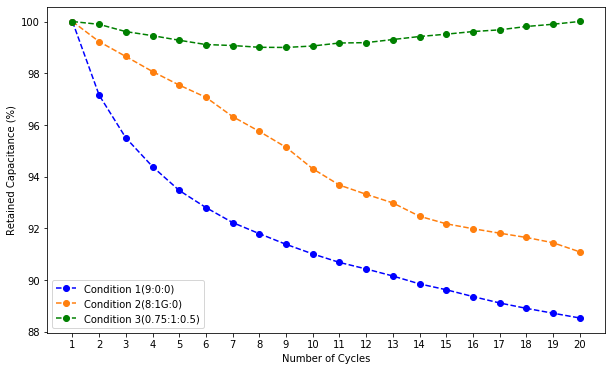

In [28]:
Cond1=[99.99999999999999,
  97.15262503123994,
  95.50085756566958,
  94.38951735406894,
  93.46839503687183,
  92.80640715220653,
  92.22704345277558,
  91.7971796609879,
  91.38522702224776,
  91.01498936062748,
  90.68618230228776,
  90.43323500614034,
  90.16083565956879,
  89.85608523079888,
  89.62936656969194,
  89.36624624577699,
  89.11826164833334,
  88.909779915219,
  88.7221415684133,
  88.53787948171984]
Cond2=[100.0,
  99.22227458174625,
  98.64734231104813,
  98.06563815558052,
  97.54176725050489,
  97.06843690514354,
  96.32338484180711,
  95.75128384604994,
  95.13695575520352,
  94.30706245236783,
  93.67556339495533,
  93.32104677245508,
  92.9859676570745,
  92.47058114346189,
  92.17949499170201,
  91.98959837260406,
  91.81678993178522,
  91.6503939225094,
  91.44712009602178,
  91.0950051786255]
Cond3=[100.0,
  99.88969501349708,
  99.60937313042233,
  99.45298488806144,
  99.27488625945072,
  99.10953959373994,
  99.0715053331281,
  99.00302683731508,
  98.9968386013719,
  99.05314523025353,
  99.16891889799396,
  99.1828840864349,
  99.30304219283516,
  99.41959172256489,
  99.51028016808569,
  99.61131344013164,
  99.6770384443021,
  99.80719862300677,
  99.89390431031546,
  100.001560235545]
plt.figure(figsize=(10,6))
#plt.axes().set_facecolor("white")
plt.plot(('1','2','3','4','5','6','7','8','9','10'
                  ,'11','12','13','14','15','16','17','18'
                  ,'19','20'),Cond1,'bo--',label='Condition 1(9:0:0)')
plt.plot(('1','2','3','4','5','6','7','8','9','10'
                  ,'11','12','13','14','15','16','17','18'
                  ,'19','20'),Cond2,'C1o--',label='Condition 2(8:1G:0)')
plt.plot(('1','2','3','4','5','6','7','8','9','10'
                  ,'11','12','13','14','15','16','17','18'
                  ,'19','20'),Cond3,'go--',label='Condition 3(0.75:1:0.5)')
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.legend(loc="lower left")
plt.xlabel('Number of Cycles')
plt.ylabel('Retained Capacitance (%)')
plt.savefig('cycles_alltogether.png', bbox_inches = 'tight')

### Plot of all averaged scan rates

#### Sample Condition 1


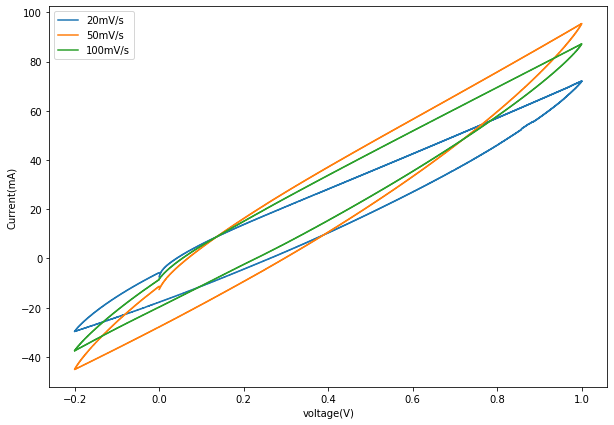

In [29]:

data_20=pd.read_excel('1 20mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_50=pd.read_excel('1 50mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_100=pd.read_excel('1 100mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)

i_20=data_20.iloc[:,::-1].mean(axis=1)
i_50=data_50.iloc[:,::-1].mean(axis=1)
i_100=data_100.iloc[:,::-1].mean(axis=1)

v_20=data_20.iloc[:,0]
v_50=data_50.iloc[:,0]
v_100=data_100.iloc[:,0]

plt.figure(figsize=(10,7))   
plt.axes().set_facecolor("white")
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.plot(v_20,i_20,label='20mV/s')
plt.plot(v_50,i_50,label='50mV/s')
plt.plot(v_100,i_100,label='100mV/s')
plt.legend(loc="upper left")
plt.xlabel('voltage(V)')
plt.ylabel('Current(mA)')
plt.savefig('Contition1.png', bbox_inches = 'tight')

#### Sample Condition 2

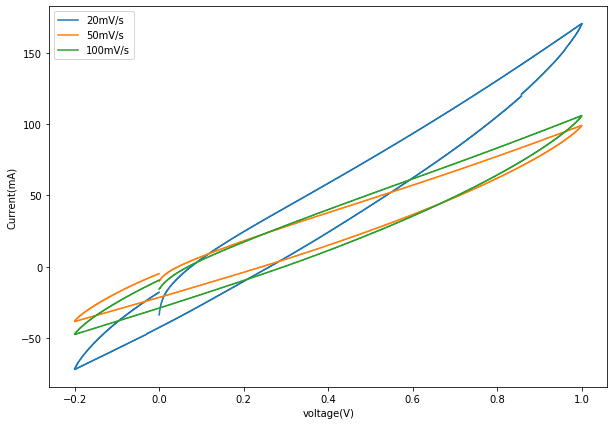

In [30]:

data_20=pd.read_excel('2 20mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_50=pd.read_excel('2 50mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_100=pd.read_excel('2 100mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)

i_20=data_20.iloc[:,1]
i_50=data_50.iloc[:,::-1].mean(axis=1)
i_100=data_100.iloc[:,::-1].mean(axis=1)

v_20=data_20.iloc[:,0]
v_50=data_50.iloc[:,0]
v_100=data_100.iloc[:,0]

plt.figure(figsize=(10,7))
plt.axes().set_facecolor("white")
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.plot(v_20,i_20,label='20mV/s')
plt.plot(v_50,i_50,label='50mV/s')
plt.plot(v_100,i_100,label='100mV/s')
plt.legend(loc="upper left")
plt.xlabel('voltage(V)')
plt.ylabel('Current(mA)')
plt.savefig('Contition2.png', bbox_inches = 'tight')

#### Sample Condition 3

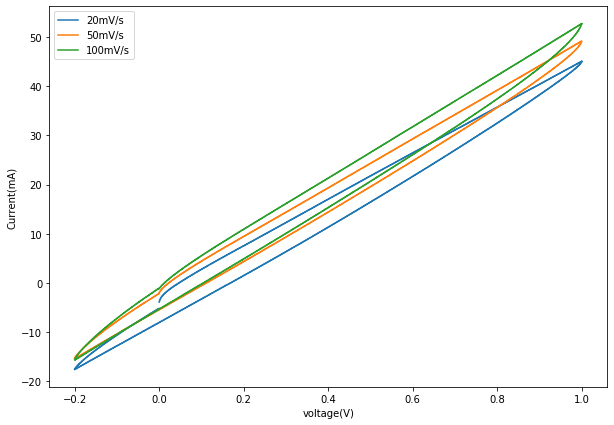

In [32]:

data_20=pd.read_excel('3 20mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_50=pd.read_excel('3 50mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_100=pd.read_excel('3 100mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)

i_20=data_20.iloc[:,::-1].mean(axis=1)
i_50=data_50.iloc[:,::-1].mean(axis=1)
i_100=data_100.iloc[:,::-1].mean(axis=1)

v_20=data_20.iloc[:,0]
v_50=data_50.iloc[:,0]
v_100=data_100.iloc[:,0]

plt.figure(figsize=(10,7))
plt.axes().set_facecolor("white")
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.plot(v_20,i_20,label='20mV/s')
plt.plot(v_50,i_50,label='50mV/s')
plt.plot(v_100,i_100,label='100mV/s')
plt.legend(loc="upper left")
plt.xlabel('voltage(V)')
plt.ylabel('Current(mA)')
plt.savefig('Contition3.png', bbox_inches = 'tight')

#### Sample Condition 4

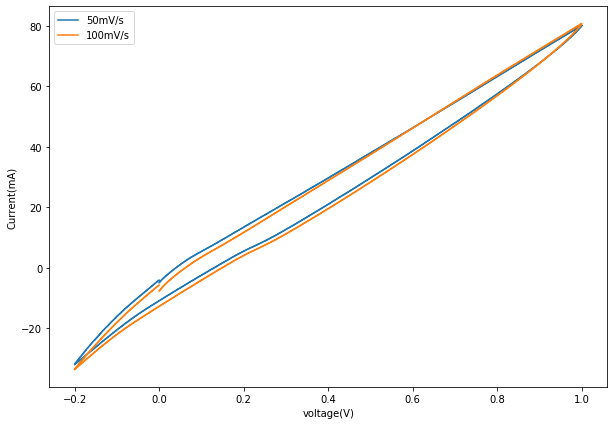

In [33]:

#data_20=pd.read_excel('4 20mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_50=pd.read_excel('4 50mVs (-0.2 to 1 V) before breakdown.xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_100=pd.read_excel('4 100mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)

#i_20=data_20.iloc[:,::-1].mean(axis=1)
i_50=data_50.iloc[:,::-1].mean(axis=1)
i_100=data_100.iloc[:,::-1].mean(axis=1)

#v_20=data_20.iloc[:,0]
v_50=data_50.iloc[:,0]
v_100=data_100.iloc[:,0]

plt.figure(figsize=(10,7))          
#plt.plot(v_20,i_20,label='20mV/s')
plt.axes().set_facecolor("white")
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.plot(v_50,i_50,label='50mV/s')
plt.plot(v_100,i_100,label='100mV/s')
plt.legend(loc="upper left")
plt.xlabel('voltage(V)')
plt.ylabel('Current(mA)')
plt.savefig('Contition4.png', bbox_inches = 'tight')

#### Sample Condition 6

In [ ]:
#6 no need
data_20=pd.read_excel('6 20mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_50=pd.read_excel('6 50mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_100=pd.read_excel('6 100mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)

i_20=data_20.iloc[:,::-1].mean(axis=1)
i_50=data_50.iloc[:,::-1].mean(axis=1)
i_100=data_100.iloc[:,::-1].mean(axis=1)

v_20=data_20.iloc[:,0]
v_50=data_50.iloc[:,0]
v_100=data_100.iloc[:,0]

plt.figure(figsize=(10,7))      
plt.axes().set_facecolor("white")
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.plot(v_20,i_20,label='20mV/s')
plt.plot(v_50,i_50,label='50mV/s')
plt.plot(v_100,i_100,label='100mV/s')
plt.legend(loc="upper left")
plt.xlabel('voltage(V)')
plt.ylabel('Current(mA)')
plt.savefig('Contition6.png', bbox_inches = 'tight')

#### Pure Cu

In [ ]:
#Cu
data_20=pd.read_excel('Cu 20mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_50=pd.read_excel('Cu 50mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)
data_100=pd.read_excel('Cu 100mVs (-0.2 to 1 V).xlsx').iloc[1:,:].dropna('columns', thresh=100)

i_20=data_20.iloc[:,::-1].mean(axis=1)
i_50=data_50.iloc[:,::-1].mean(axis=1)
i_100=data_100.iloc[:,::-1].mean(axis=1)

v_20=data_20.iloc[:,0]
v_50=data_50.iloc[:,0]
v_100=data_100.iloc[:,0]

plt.figure(figsize=(10,7))      
plt.axes().set_facecolor("white")
#plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.plot(v_20,i_20,label='20mV/s')
plt.plot(v_50,i_50,label='50mV/s')
plt.plot(v_100,i_100,label='100mV/s')
plt.legend(loc="upper left")
plt.xlabel('voltage(V)')
plt.ylabel('Current(mA)')
plt.savefig('Contition_just_Cu.png', bbox_inches = 'tight')

#### Function for Calculating Specific Power

In [ ]:
def specific_power (Cs):
    P=Cs*1.2**2
    return P
specific_power (30.2616249 )